In [ ]:
# Stereo Depth Estimation

# Upload left/right images here
from google.colab import files
uploaded = files.upload()

Saving tree_r.png to tree_r.png
Saving SHRUB-15.png to SHRUB-15.png
Saving scene_r.png to scene_r.png
Saving meter_r.png to meter_r.png


In [ ]:
# Required Imports
import os
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# Dataset for Folder-Based Stereo Pairs
class StereoFolderDataset(Dataset):
    def __init__(self, left_folder, right_folder, transform=None):
        self.left_imgs = sorted([
            os.path.join(left_folder, f) for f in os.listdir(left_folder)
            if os.path.isfile(os.path.join(left_folder, f))
        ])
        self.right_imgs = sorted([
            os.path.join(right_folder, f) for f in os.listdir(right_folder)
            if os.path.isfile(os.path.join(right_folder, f))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.left_imgs)

    def __getitem__(self, idx):
        left_img = Image.open(self.left_imgs[idx]).convert("RGB")
        right_img = Image.open(self.right_imgs[idx]).convert("RGB")

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        return left_img, right_img

In [ ]:
# Deep Learning Stereo Network (for demonstration)
class StereoNet(nn.Module):
    def __init__(self):
        super(StereoNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, left, right):
        x = torch.cat((left, right), dim=1)  # Concatenate along channel axis
        x = self.encoder(x)
        return x

In [ ]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor()
])

In [ ]:
# Paths
left_path = "/content/stereo_data/left"
right_path = "/content/stereo_data/right"

In [ ]:
# Load Dataset
dataset = StereoFolderDataset(left_path, right_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# Load Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StereoNet().to(device)
model.eval()

StereoNet(
  (encoder): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

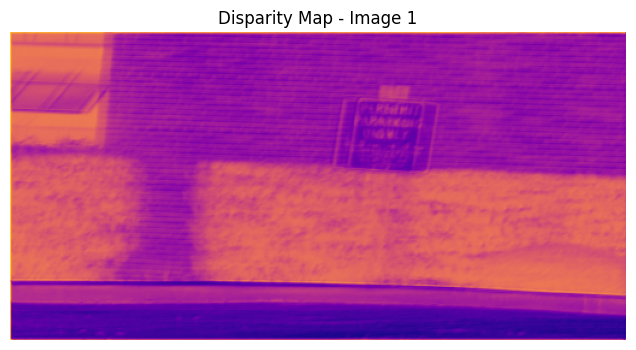

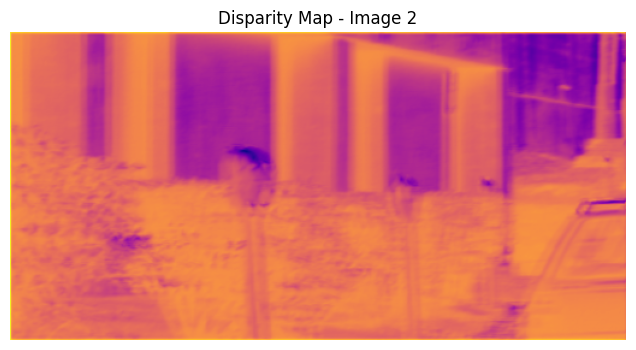

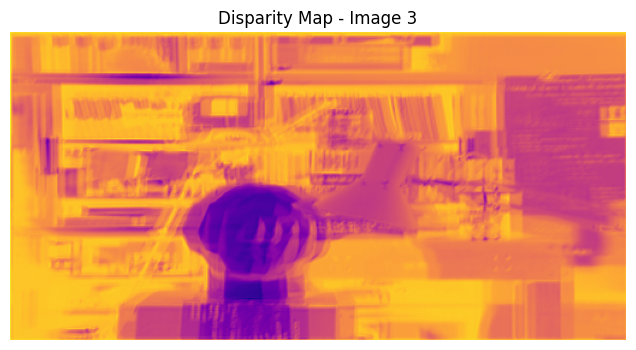

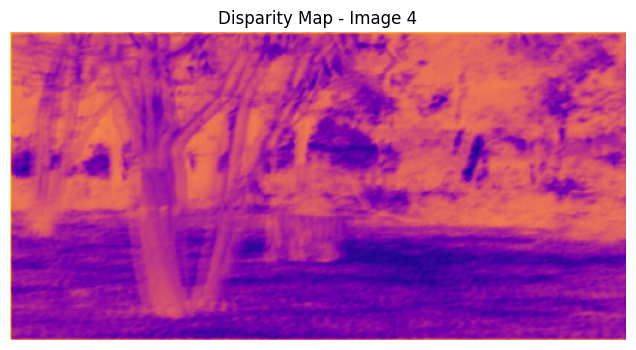

In [ ]:
# Inference Loop
with torch.no_grad():
    for i, (left, right) in enumerate(dataloader):
        left, right = left.to(device), right.to(device)
        pred = model(left, right)
        pred_np = pred.squeeze().cpu().numpy()

        # Display
        plt.figure(figsize=(10, 4))
        plt.imshow(pred_np, cmap='plasma')
        plt.title(f'Disparity Map - Image {i+1}')
        plt.axis('off')
        plt.show()